# **Importing the Modules**

In [1]:
#pip install tensorflow[and-cuda]

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization 

2024-11-27 08:02:22.147284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 08:02:22.147455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 08:02:22.339421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Loading the Dataset**

In [3]:
TRAIN_DIR =  "/kaggle/input/facial-expression-dataset/train/train/"
TEST_DIR =  "/kaggle/input/facial-expression-dataset/test/test/"

In [4]:
'''Load image data from the given directory containing the image data'''
def load_imgdata(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory + label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed" )

    return image_paths, labels #It returns A list of image paths and a list of corresponding labels


In [5]:
train = pd.DataFrame()

# Load image data into the DataFrame
train['image'], train['label'] = load_imgdata(TRAIN_DIR)

# Shuffling of the training data
train = train.sample(frac = 1).reset_index(drop = True)

train.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/facial-expression-dataset/train/...,happy
1,/kaggle/input/facial-expression-dataset/train/...,sad
2,/kaggle/input/facial-expression-dataset/train/...,sad
3,/kaggle/input/facial-expression-dataset/train/...,sad
4,/kaggle/input/facial-expression-dataset/train/...,happy


In [6]:
test = pd.DataFrame()
test['image'], test['label'] = load_imgdata(TEST_DIR)

test.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/facial-expression-dataset/test/t...,surprise
1,/kaggle/input/facial-expression-dataset/test/t...,surprise
2,/kaggle/input/facial-expression-dataset/test/t...,surprise
3,/kaggle/input/facial-expression-dataset/test/t...,surprise
4,/kaggle/input/facial-expression-dataset/test/t...,surprise


# **Exploratory Data Analysis (EDA)**

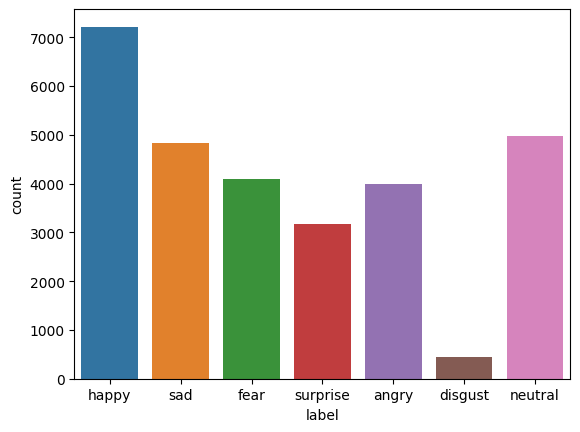

In [7]:
# Creating a countplot
sns.countplot(data=train, x='label')
plt.show()


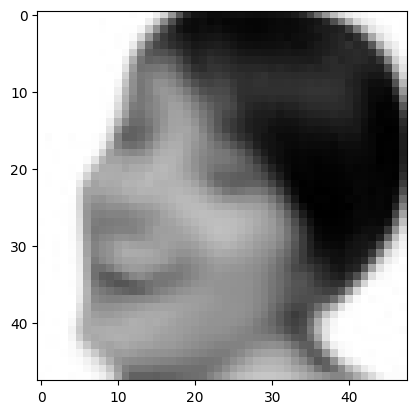

In [8]:
from PIL import Image

img = Image.open(train['image'][0])
plt.imshow(img,cmap='gray');

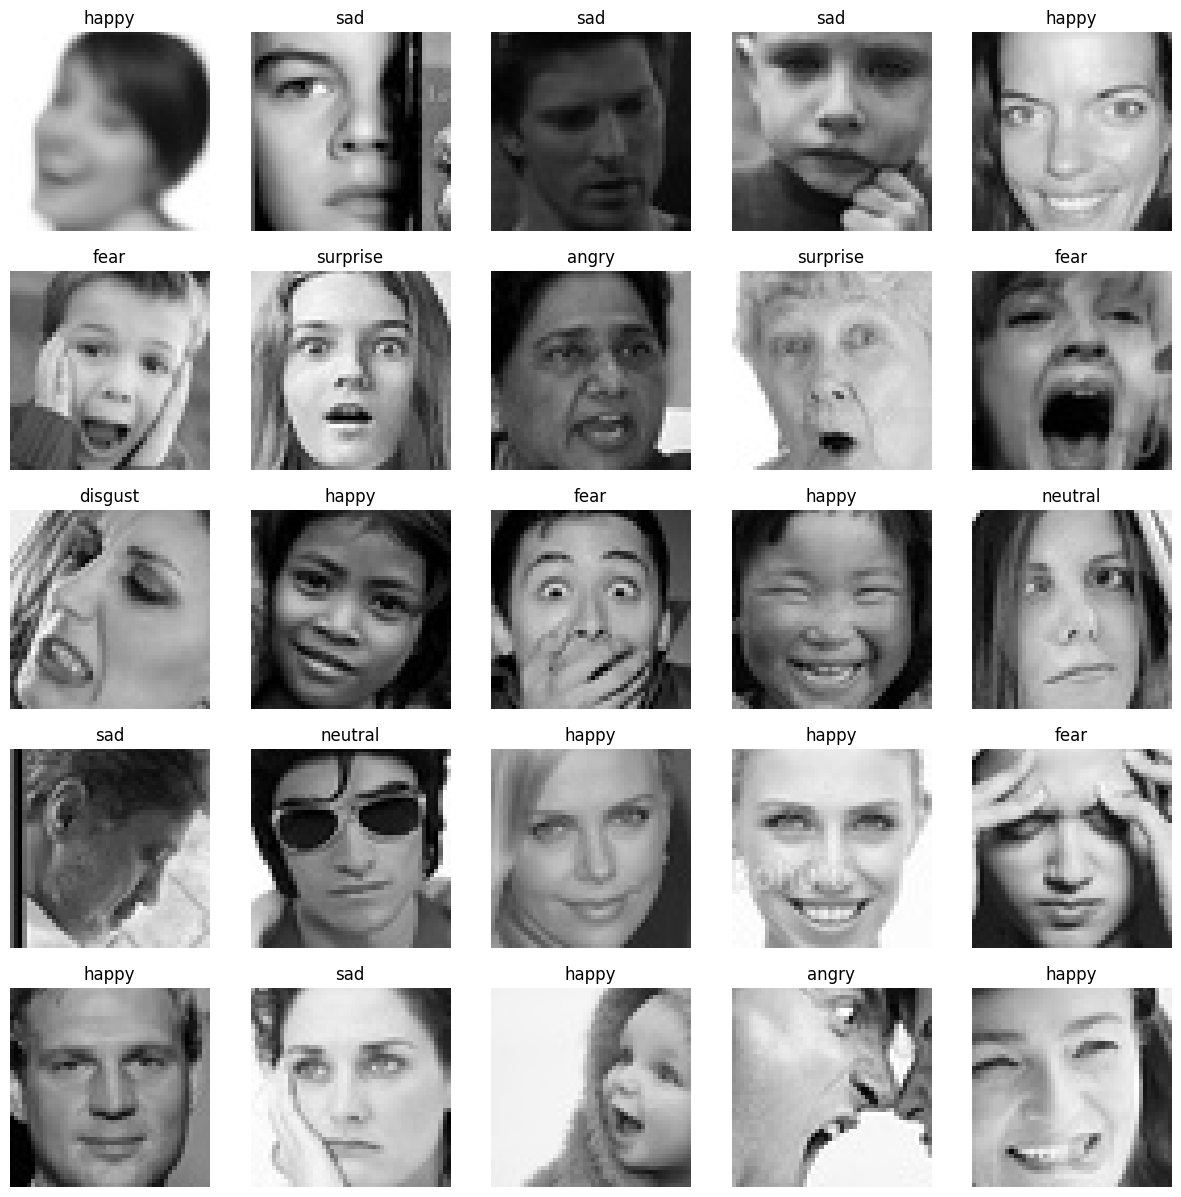

In [9]:
#Plot a grid of images and their corresponding labels.
plt.figure(figsize=(15,15))
files = train.iloc[0:25]

for idx, file, label in files.itertuples():
    plt.subplot(5,5,idx+1)
    image = load_img(file)
    image = np.array(image)
    plt.imshow(image,cmap='gray')
    plt.title(label)
    plt.axis('off')

# **Feature Extraction**

In [10]:

def extract_features(images):
    features = []
    
    for file in tqdm(images):
        img = load_img(file,grayscale=True)
        img = np.array(img)
        features.append(img)
    
    features = np.array(features).reshape(len(features),48,48,1)
    return features

In [11]:
# Extract features from the 'train' dataframe
feat_train = extract_features(train['image'])


  0%|          | 0/28709 [00:00<?, ?it/s]

In [12]:
# Extract features from the 'test' images

feat_test = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [13]:
# Normalize the pixel values of the training & testing set
X_train = feat_train / 255.0
X_test = feat_test / 255.0

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train['label']) #Fit & transform the 'label' column of 'train' DataFrame
y_test = le.transform(test['label']) # Transform the 'label' column of 'test' DataFrame

In [15]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)

**Create the Convolutional Neural Network (CNN) model**

In [16]:
cnn = Sequential()

#Convolutional Layer(s)
cnn.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',input_shape=(48,48,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))
cnn.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))
cnn.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))
cnn.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.32))

# Flatten
cnn.add(Flatten())

#Fully-Connected Layer(s)
cnn.add(Dense(units=512,activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))
cnn.add(Dense(units=512,activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# Output Layer
cnn.add(Dense(units=7,activation='softmax'))

In [17]:
# Compiling the loss function, optimizer, and accuracy of the model
cnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# **Training**

In [18]:
r = cnn.fit(x=X_train,y=y_train,batch_size=128,epochs=21,validation_data=(X_test,y_test))

Epoch 1/21
225/225 [==============================] - 754s 3s/step - loss: 2.0221 - accuracy: 0.2641 - val_loss: 1.9148 - val_accuracy: 0.2471
Epoch 2/21
225/225 [==============================] - 751s 3s/step - loss: 1.5343 - accuracy: 0.4217 - val_loss: 1.5821 - val_accuracy: 0.4047
Epoch 3/21
225/225 [==============================] - 753s 3s/step - loss: 1.3370 - accuracy: 0.4947 - val_loss: 1.3326 - val_accuracy: 0.4880
Epoch 4/21
225/225 [==============================] - 763s 3s/step - loss: 1.2306 - accuracy: 0.5329 - val_loss: 1.2717 - val_accuracy: 0.5205
Epoch 5/21
225/225 [==============================] - 749s 3s/step - loss: 1.1456 - accuracy: 0.5673 - val_loss: 1.2529 - val_accuracy: 0.5301
Epoch 6/21
225/225 [==============================] - 738s 3s/step - loss: 1.0809 - accuracy: 0.5901 - val_loss: 1.1673 - val_accuracy: 0.5580
Epoch 7/21
225/225 [==============================] - 734s 3s/step - loss: 1.0170 - accuracy: 0.6139 - val_loss: 1.3725 - val_accuracy: 0.5327

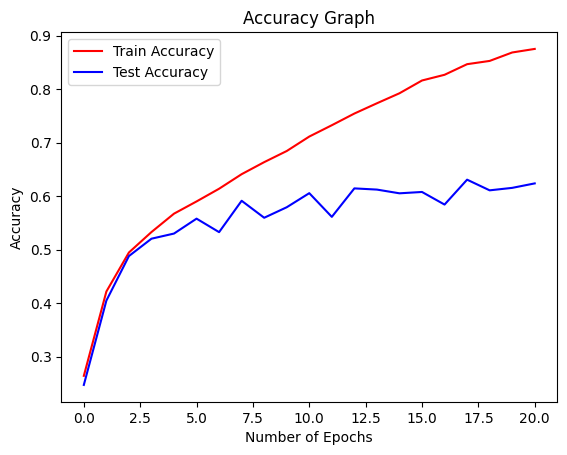

In [19]:
# Extracting accuracy and validation accuracy from history
accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']
epochs = range(len(accuracy))

plt.plot(epochs,accuracy,'r',label='Train Accuracy')
plt.plot(epochs,val_accuracy,'b',label='Test Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend();

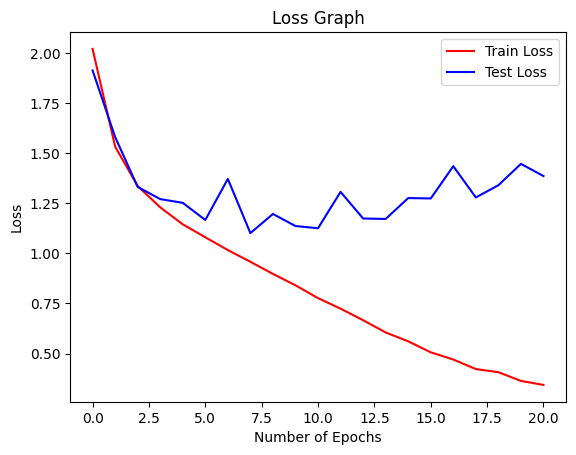

In [20]:
# Extracting loss and validation loss
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs,loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'b',label='Test Loss')
plt.title('Loss Graph')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend();

# **Testing**

Original Output Label: happy
1/1 [==============================] - 0s 278ms/step
Predicted O/p Label: happy


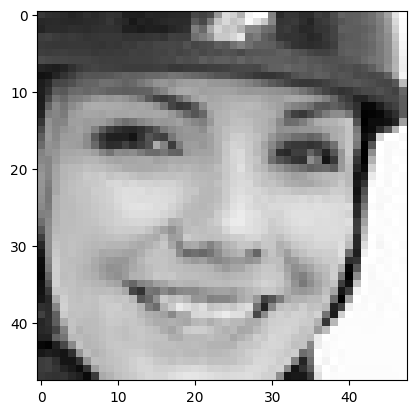

In [21]:
'''Get a random image label and make a prediction using the given CNN model'''
import random

img_indx = random.randint(0,len(test))
print("Original Output Label:", test['label'][img_indx])
pred = cnn.predict(X_test[img_indx].reshape(1,48,48,1))
predicted_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted O/p Label:", predicted_label)
plt.imshow(X_test[img_indx].reshape(48,48),cmap='gray');